In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model,Sequential
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn import metrics
import tensorflow as tf
import itertools

In [2]:
def data_preparation(df):
    category = df.pop('category')
    subcategory = df.pop('subcategory')
    attack = df.pop('attack')
    
    del df['pkSeqID']
    del df['flgs']
    del df['saddr']    
    del df['sport']    
    del df['daddr']    
    del df['dport']
    del df['smac']
    del df['dmac']
    del df['soui']
    del df['doui']
    del df['sco']
    del df['dco']
    del df['stime']
    del df['seq']

    
    df.loc[df['state'] == 'CON','state'] = 0
    df.loc[df['state'] == 'FIN','state'] = 1
    df.loc[df['state'] == 'INT','state'] = 2
    df.loc[df['state'] == 'NRS','state'] = 3
    df.loc[df['state'] == 'RST','state'] = 4
    df.loc[df['state'] == 'URP','state'] = 5
    df.loc[df['state'] == 'REQ','state'] = 6
    df.loc[df['state'] == 'ECO','state'] = 7
    df.loc[df['state'] == 'MAS','state'] = 8
    df.loc[df['state'] == 'PAR','state'] = 9
    df.loc[df['state'] == 'TST','state'] = 10



    df.loc[df['proto'] == 'arp','proto'] = 0
    df.loc[df['proto'] == 'icmp','proto'] = 1
    df.loc[df['proto'] == 'ipv6-icmp','proto'] = 2
    df.loc[df['proto'] == 'tcp','proto'] = 3
    df.loc[df['proto'] == 'udp','proto'] = 4
    df.loc[df['proto'] == 'igmp','proto'] = 5
    df.loc[df['proto'] == 'rarp','proto'] = 6

    df = df.astype(np.float32)
    
    for column in df.columns:
        df[column] = df[column]/max(df[column])
    
    category.loc[category == 'DDoS'] = 0
    category.loc[category == 'DoS'] = 1
    category.loc[category == 'Normal'] = 2
    category.loc[category == 'Reconnaissance'] = 3
    category.loc[category == 'Theft'] = 4
    
    category = keras.utils.to_categorical(category, 5)
    
    
    return df, category

In [3]:
def prepare_data(df_file_path):
    df = pd.read_csv(df_file_path)
    df.columns = ['DELETED', 'time', 'DELETED', 'srvc', 'ipv4', 'sip', 'dip', 'len', 
                  'DELETED', 'DELETED', 'DELETED', 'DELETED', 'DELETED', 'DELETED', 
                  'DELETED', 'curdur', 'dtime', 'hlen', 'DELETED', 'DELETED', 'DELETED',
                  'DELETED', 'DELETED', 'DELETED', 'DELETED', 'DELETED', 'DELETED', 
                  'dport', 'sport', 'rsrvd', 'nnc', 'cwr', 'ecn', 'urg', 'ack', 
                  'push', 'rst', 'syn', 'fin']

    del df['DELETED']


    flags = ['rsrvd', 'nnc', 'cwr', 'ecn','urg', 'ack', 'push', 'rst', 'syn', 'fin']
    for col in flags:
        df.loc[df[col] == 'Not set', col] = 0
        df.loc[df[col] == 'Set', col] = 1
    
    df = df.fillna(0)
    df['dport'] = df['dport'].astype(np.int)
    df['sport'] = df['sport'].astype(np.int)
    df['hlen'] = df['hlen'].astype(np.int)
    return df




In [4]:
def prepare_Michael_data(dos_file_path, normal_file_path, recon_file_path):
    dos = prepare_data(dos_file_path)
    search_ip = ['192.168.50.150', '192.168.50.210']
    for ip in set(dos['sip']):
        if ip not in search_ip:
            dos = dos.drop(dos[dos.sip == ip].index)

    for ip in set(dos['dip']):
        if ip not in search_ip:
            dos = dos.drop(dos[dos.dip == ip].index)
            
            
    normal = prepare_data(normal_file_path)
    normal = normal.drop(normal[~((normal.sip == '192.168.50.150') | (normal.dip == '192.168.50.150'))].index)
    
    recon = prepare_data(recon_file_path)
    ip_main = '192.168.100.55'
    recon = recon.drop(recon[~((recon.sip == ip_main) | (recon.dip == ip_main))].index)
    
    dos['category'] ='dos'
    normal['category'] = 'normal'
    recon['category'] = 'recon'
    
    summary = pd.concat([dos, normal, recon]).reset_index(drop=True)
    ipv4 = pd.get_dummies(summary['ipv4'])
    ipv4['ICMP'] = 0
    print(ipv4.head())
    ipv4['ICMP'] += ipv4['ICMP,UDP']
    ipv4['UDP'] += ipv4['ICMP,UDP']
    del ipv4['ICMP,UDP']
    
    srvc = pd.get_dummies(summary['srvc'])
    summary[ipv4.columns] = ipv4
    summary[srvc.columns] = srvc

    del summary['srvc']
    del summary['ipv4']
    
    
    land = summary['sport'] == summary['dport']
    land[land == True] = 1
    land[land == False] = 0
    del summary['dport']
    del summary['sport']
    summary['land'] = land.astype(np.int)

    
    dos = summary[summary['category'] == 'dos']
    normal = summary[summary['category'] == 'normal']
    recon = summary[summary['category'] == 'recon']
    
    
    src_bytes = sum(dos['len'][dos['sip'] == '192.168.50.150'])
    dst_bytes = sum(dos['len'][dos['sip'] == '192.168.50.210'])
    sbps = src_bytes / (max(dos['time']) - min(dos['time']))
    dbps = dst_bytes / (max(dos['time']) - min(dos['time']))
    dos['src_bytes'] = src_bytes
    dos['dst_bytes'] = dst_bytes
    dos.loc[dos['sip'] == '192.168.50.210', 'src_bytes'] = dst_bytes
    dos.loc[dos['sip'] == '192.168.50.210', 'dst_bytes'] = src_bytes
    dos['sbps'] = sbps
    dos['dbps'] = dbps
    dos.loc[dos['sip'] == '192.168.50.210', 'sbps'] = dbps
    dos.loc[dos['sip'] == '192.168.50.210', 'dbps'] = sbps
    
    print('dos: 100%\nnormal:')
    
    ip_list = set(normal.sip)
    df = pd.DataFrame([[0 for i in ip_list] for j in ip_list], columns= ip_list, index= ip_list)
    for dip in ip_list:
        df['192.168.50.150'][dip] = sum(normal['len'][(normal['dip'] == dip) & (normal['sip'] == '192.168.50.150')])
    for sip in ip_list:
        df[sip]['192.168.50.150'] = sum(normal['len'][(normal['sip'] == sip) & (normal['dip'] == '192.168.50.150')])


    normal[['src_bytes', 'dst_bytes']] = [0, 0]

    for (i, j, k) in zip(normal['sip'], normal['dip'], normal.index):
        if i == '192.168.50.150':
            if j !='192.168.50.255' and j != '239.255.255.250' and j != '224.0.0.251' and j != '192.168.50.243':
                normal['src_bytes'][k] = df['192.168.50.150'][j]
                normal['dst_bytes'][k] = df[j]['192.168.50.150']
        else:
            if j == '192.168.50.150':
                normal['src_bytes'][k] = df[i]['192.168.50.150']
                normal['dst_bytes'][k] = df['192.168.50.150'][i]
        if k % 10000 == 0:
            print(((k - min(normal.index)) / (max(normal.index) - min(normal.index)))* 100)

    normal['sbps'] = normal['src_bytes'] / (max(normal['time'] - min(normal['time'])))
    normal['dbps'] = normal['dst_bytes'] / (max(normal['time'] - min(normal['time'])))

    print('normal: 100%\nrecon:')

    
    ip_list = set(recon.sip)
    df = pd.DataFrame([[0 for i in ip_list] for j in ip_list], columns= ip_list, index= ip_list)
    for dip in ip_list:
        df[ip_main][dip] = sum(recon['len'][(recon['dip'] == dip) & (recon['sip'] == ip_main)])
    for sip in ip_list:
        df[sip][ip_main] = sum(recon['len'][(recon['sip'] == sip) & (recon['dip'] == ip_main)])
    recon[['src_bytes', 'dst_bytes']] = [0, 0]

    for (i, j, k) in zip(recon['sip'], recon['dip'], recon.index):
        if i == ip_main:
            recon['src_bytes'][k] = df[ip_main][j]
            recon['dst_bytes'][k] = df[j][ip_main]
        else:
            if j == ip_main:
                recon['src_bytes'][k] = df[i][ip_main]
                recon['dst_bytes'][k] = df[ip_main][i]
        if k % 10000 == 0:
            print( ((k - min(recon.index)) / (max(recon.index) - min(recon.index))) * 100, '%')

    recon['sbps'] = recon['src_bytes'] / (max(recon['time'] - min(recon['time'])))
    recon['dbps'] = recon['dst_bytes'] / (max(recon['time'] - min(recon['time'])))
    print('100%')

    #del dos['time']
    #del normal['time']
    #del recon['time']
    #del dos['sip']
    #del normal['sip']
    #del recon['sip']
    #del dos['dip']
    #del normal['dip']
    #del recon['dip']
    #del dos['category']
    #del normal['category']
    #del recon['category']

    return dos, normal, recon

In [5]:
def normalize(df_orig):
    x = df_orig.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_normalized = pd.DataFrame(x_scaled, columns = df_orig.columns, index= df_orig.index)
    return df_normalized

In [21]:
def plot_confusion_matrix(Y, X, normalize=True, cmap=plt.cm.winter):
    cm = confusion_matrix(Y, X)
    plt.figure(figsize=(7, 5))
    font = {'size' : 15}
    plt.rc('font', **font)
    classes=['positive', 'Negative']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if np.isnan(cm[i, j]):
            cm[i, j] = 0.0
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Error matrix', fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12, rotation=45)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=14)
    
    plt.tight_layout()
    plt.ylabel('True-label', fontsize=20)
    plt.xlabel('Predicted-label', fontsize=20)

    return plt

In [22]:
def roc_calc(model, testX, testy):
    ns_probs = [0 for _ in range(len(testy))]
    lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
    lr_probs = lr_probs[:]
# calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    
def define_metrics(y_test, y_predicted, y_predicted_proba):  
    # точность(precision)
    precision = metrics.precision_score(y_test, y_predicted, pos_label=None, average='weighted')             
    # Полнота (recall)
    recall = metrics.recall_score(y_test, y_predicted, pos_label=None, average='weighted') 
    # F-мера - среднее точности и полноты
    f1 = metrics.f1_score(y_test, y_predicted, pos_label=None, average='weighted')    
    # Accuracy – доля правильных ответов алгоритма
    accuracy = metrics.accuracy_score(y_test, y_predicted)
    #Коэффициент корреляции Мэтьюза: +1 представляет идеальное предсказание, 
    # 0 - среднее случайное предсказание и -1 - обратное предсказание. 
    matthews_corrcoef = metrics.matthews_corrcoef(y_test, y_predicted)
    try:
        #Вычислить площадь под кривой рабочих характеристик приемника (ROC AUC) по оценкам прогнозов.
        roc_auc_ovr = metrics.roc_auc_score(y_test, y_predicted_proba, average='weighted', multi_class='ovr')
    except ValueError:
        roc_auc_ovr = '-'
    
    try:
        #Функция правдоподобия отвечает на вопрос:«Насколько вероятным, по мнению модели,
        #  был фактически наблюдаемый набор результатов»
        log_loss = metrics.log_loss(y_test, y_predicted_proba)
    except ValueError:
        log_loss = '-'
    
    return ['Accuracy', 'Precision', 'Recall', 'F-score', 'MСС', 'ROC AUC', 'Log Loss'], \
           [accuracy,    precision,   recall,   f1,    matthews_corrcoef,    roc_auc_ovr, log_loss]


def merge(y_predicted_proba, y_test):
    norm_ind = list(label_encoder.transform(['Normal']))[0]
    y_test_2 = [0 if x == norm_ind else 1 for x in y_test]
    y_predicted_counts_2 = [[x[norm_ind], sum(x) - x[norm_ind]] for x in y_predicted_proba]
    return y_predicted_counts_2, y_test_2

def print_stats(y_predicted_counts_proba_, y_test_, encoder, atk_norm=False):
    if atk_norm:
        y_predicted_counts_proba, y_test, = merge(y_predicted_counts_proba_, y_test_)
    else:
        y_predicted_counts_proba, y_test = y_predicted_counts_proba_, y_test_
    
    y_predicted_counts = np.array(y_predicted_counts_proba).argmax(axis=-1)
    keys, vals = define_metrics(y_test, y_predicted_counts, y_predicted_counts_proba)
    stats = pd.DataFrame([[round(x, 3) if not type(x) == str else x for x in vals]], columns=keys, index=['    '])
    display(stats)
    
    fig_scale = 0.6 if atk_norm else 0.9
    # В одной строке разместим 2 графика (график, табл)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[int(fig_scale * x) for x in (16, 7)])
    # ROC
    _ = skplt.metrics.plot_roc(y_test, y_predicted_counts_proba, figsize=(int(14*0.7), int(10*0.7)), plot_micro=False, plot_macro=False, ax=axs[0])
    
    if atk_norm:
        cm = metrics.confusion_matrix(y_test, y_predicted_counts, [0, 1])
        _ = plot_confusion_matrix(cm, ['Normal', 'Attack'], normalize=True, title='Error matrix')
    else:
        cm = metrics.confusion_matrix(y_test, y_predicted_counts, encoder.transform(encoder.classes_))
        _ = plot_confusion_matrix(cm, encoder.classes_, normalize=True, title='Error matrix')
    plt.show()
    
    return stats

#время
TIME = list()

def t_start() -> float:
    return time.process_time()

def t_end(msg: str, start: float) -> None:
    global TIME
    interval = time.process_time() - start
    print('{:32} : {:2.3f} s'.format(msg, interval))
    TIME.append([msg, interval])

In [8]:
#dos.to_csv(r'C:\Users\Евгений\Desktop\7 семестр\Нейронки\datasets\dosfinal.csv', sep=',', encoding='utf-8', index=False)
#normal.to_csv(r'C:\Users\Евгений\Desktop\7 семестр\Нейронки\datasets\normalfinal.csv', sep=',', encoding='utf-8', index=False)
#recon.to_csv(r'C:\Users\Евгений\Desktop\7 семестр\Нейронки\datasets\reconfinal.csv', sep=',', encoding='utf-8', index=False)

In [9]:
dos_path = r'C:\Users\Евгений\Desktop\7 семестр\Нейронки\datasets\dosfinal.csv'
normal_path = r'C:\Users\Евгений\Desktop\7 семестр\Нейронки\datasets\normalfinal.csv'
recon_path = r'C:\Users\Евгений\Desktop\7 семестр\Нейронки\datasets\reconfinal.csv'

dos= pd.read_csv(dos_path)
normal= pd.read_csv(normal_path)
recon= pd.read_csv(recon_path)

In [10]:
normal.columns

Index(['time', 'sip', 'dip', 'len', 'curdur', 'dtime', 'hlen', 'rsrvd', 'nnc',
       'cwr', 'ecn', 'urg', 'ack', 'push', 'rst', 'syn', 'fin', 'category',
       'TCP', 'UDP', 'ICMP', 'DCP-PFT', 'DNS', 'HTTP', 'MDNS', 'NBNS', 'NTP',
       'OCSP', 'QUIC', 'SSDP', 'SSL', 'SSLv2', 'TLSv1.2', 'TLSv1.3', 'land',
       'src_bytes', 'dst_bytes', 'sbps', 'dbps'],
      dtype='object')

In [11]:
df = pd.concat([dos,normal,recon])
del df['time']
del df['sip']
del df['dip']

category = df.pop('category')

df_normalized = normalize(df)
df = df.fillna(0)

In [12]:
dos_normalized = df_normalized[category == 'dos']
normal_normalized = df_normalized[category == 'normal']
recon_normalized = df_normalized[category == 'recon']

In [13]:
#dos.to_csv(r'C:\Users\Евгений\Desktop\7 семестр\Нейронки\datasets\dosfinal.csv', sep=',', encoding='utf-8', index=False)
#normal.to_csv(r'C:\Users\Евгений\Desktop\7 семестр\Нейронки\datasets\normalfinal.csv', sep=',', encoding='utf-8', index=False)
#recon.to_csv(r'C:\Users\Евгений\Desktop\7 семестр\Нейронки\datasets\reconfinal.csv', sep=',', encoding='utf-8', index=False)

In [14]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=100)
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan


In [15]:
def train(gan, discriminator, generator, df, epochs=1, batch_size=128):
    
    batch_count = len(df) // batch_size
    history_dis =[]
    history_gen = []
    for e in range(1, epochs+1):
        for _ in tqdm(range(batch_count)):
            
            # Get a random set of input noise and packets
            noise = np.random.uniform(0, 1, size=[batch_size, 100])
            real_packets = df.loc[np.random.randint(0, len(df), size= batch_size)]

            # Generate fake packets
            generated_packets = generator.predict(noise)
            X = np.concatenate([real_packets, generated_packets])

            # Labels for generated and real data
            y_dis = np.ones(2 * batch_size)
            # One-sided label smoothing
            y_dis[batch_size:] = 0

            # Train discriminator
            discriminator.trainable = True
            history_dis.append(discriminator.train_on_batch(X, y_dis))

            # Train generator
            noise = np.random.uniform(0, 1, size=[batch_size, 100])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            history_gen.append(gan.train_on_batch(noise, y_gen))
        print('-'*15, 'Epoch %d' % e, '-'*15)
    return history_dis, history_gen

In [16]:
train_dos, test_dos, reserv_dos = np.split(dos_normalized, [int(.5*len(dos_normalized)), int(.7*len(dos_normalized))])
train_normal, test_normal, reserv_normal = np.split(normal_normalized, [int(.5*len(normal_normalized)), int(.7*len(normal_normalized))])
train_recon, test_recon = np.split(recon_normalized, [int(.8*len(recon_normalized))])

  0%|▏                                                                                 | 1/564 [00:00<01:00,  9.28it/s]

--------------- Epoch 1 ---------------


  0%|▏                                                                                 | 1/564 [00:00<01:00,  9.33it/s]

--------------- Epoch 2 ---------------


  0%|▏                                                                                 | 1/564 [00:00<01:07,  8.32it/s]

--------------- Epoch 3 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 564/564 [01:06<00:00,  8.50it/s]


--------------- Epoch 4 ---------------


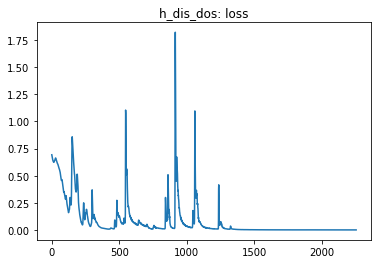

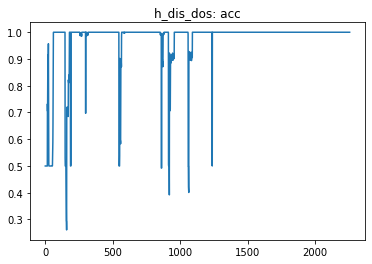

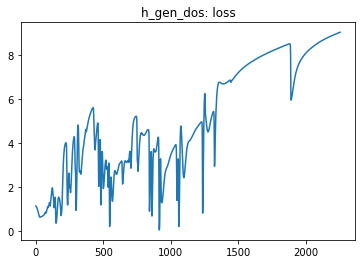

In [17]:
dis_dos = keras.Sequential([
    Dense(35, activation='relu'),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])
dis_dos.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

gen_dos = keras.Sequential([
    Dense(100, activation='relu'),
    Dense(76, activation='relu'),
    Dense(35, activation='sigmoid')
])
gen_dos.compile(optimizer='adam', loss='binary_crossentropy')

gan_dos = create_gan(dis_dos,gen_dos)


h_dis_dos, h_gen_dos = train(gan_dos, dis_dos, gen_dos,train_dos, 4, 500)

plt.title('h_dis_dos: loss')
plt.plot([h_dis_dos[y][0] for y in range(len(h_dis_dos))])
plt.show()

plt.title('h_dis_dos: acc')
plt.plot([h_dis_dos[y][1] for y in range(len(h_dis_dos))])
plt.show()

plt.title('h_gen_dos: loss')
plt.plot(h_gen_dos)
plt.show()

In [18]:
#print('itself:')
size= len(test_dos)
noise = np.random.uniform(0, 1, size=[size, 100])
generated_packets = gen_dos.predict(noise)
real_packets = test_dos[:size]
X1 = np.concatenate([real_packets, generated_packets])
y_dis1 = np.ones(2 * size)
y_dis1[size:] = 0
#dis_dos.evaluate(X1, y_dis1)
#roc_calc(dis_dos, X1, y_dis1)

#print('\n\nrecon:')
size= min(len(test_dos), len(recon_normalized))
noise = np.random.uniform(0, 1, size=[size, 100])
generated_packets = recon_normalized[:size]
real_packets = test_dos[:size]
X2 = np.concatenate([real_packets, generated_packets])
y_dis2 = np.ones(2 * size)
y_dis2[size:] = 0
#dis_dos.evaluate(X2, y_dis2)
#roc_calc(dis_dos, X2, y_dis2)

#print('\n\nnormal:')
size= min(len(test_dos), len(normal_normalized))
noise = np.random.uniform(0, 1, size=[size, 100])
generated_packets = normal_normalized[:size]
real_packets = test_dos[:size]
X3 = np.concatenate([real_packets, generated_packets])
y_dis3 = np.ones(2 * size)
y_dis3[size:] = 0
#dis_dos.evaluate(X3, y_dis3)
#roc_calc(dis_dos, X3, y_dis3)

18237/18237 [==============================] - 22s 1ms/step - loss: 0.0011 - accuracy: 1.0000



Instructions for updating:
Please use `model.predict()` instead.
No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


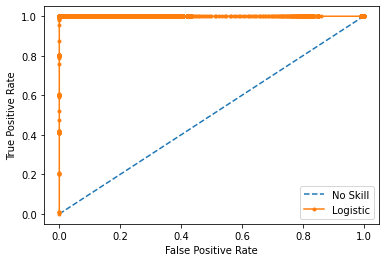

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-score: 1.0
MСС: 1.0
ROC AUC: 1.0
Log Loss: 0.00112228160603881


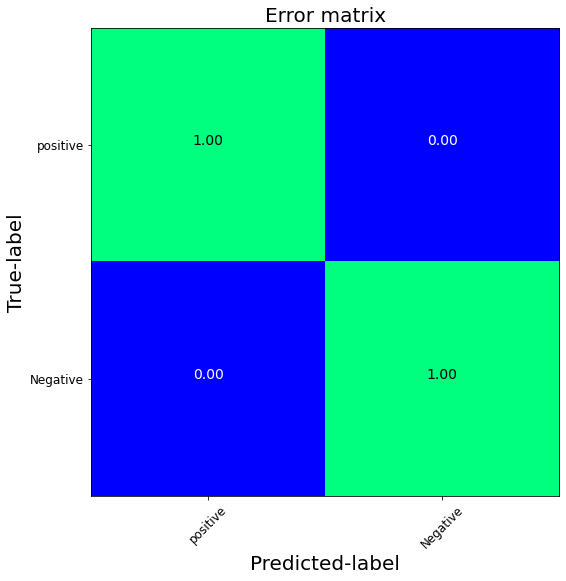

In [19]:
### FINAL CHECK FOR DOS DISCRIMINATOR
X = np.concatenate([X1, X2, X3])
Y = np.concatenate([y_dis1, y_dis2, y_dis3])
dis_dos.evaluate(X, Y)
print('\n\n')
roc_calc(dis_dos, X, Y)
y_predicted_proba = dis_dos.predict(X)
stat_name, stat_value = define_metrics(Y, np.round(y_predicted_proba), y_predicted_proba)
for i in range(len(stat_name)):
    print(stat_name[i] + ':', stat_value[i])
    

plot_confusion_matrix(Y, np.round(dis_dos.predict(X)))
plt.show()

  0%|▎                                                                                 | 2/526 [00:00<00:31, 16.71it/s]

--------------- Epoch 1 ---------------


  0%|                                                                                          | 0/526 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------


  0%|▎                                                                                 | 2/526 [00:00<00:33, 15.43it/s]

--------------- Epoch 3 ---------------


  0%|▎                                                                                 | 2/526 [00:00<00:29, 17.64it/s]

--------------- Epoch 4 ---------------


  0%|▏                                                                                 | 1/526 [00:00<00:57,  9.20it/s]

--------------- Epoch 5 ---------------


  0%|▎                                                                                 | 2/526 [00:00<00:30, 17.18it/s]

--------------- Epoch 6 ---------------


  0%|▎                                                                                 | 2/526 [00:00<00:35, 14.75it/s]

--------------- Epoch 7 ---------------


  0%|▎                                                                                 | 2/526 [00:00<00:31, 16.88it/s]

--------------- Epoch 8 ---------------


  0%|▎                                                                                 | 2/526 [00:00<00:42, 12.25it/s]

--------------- Epoch 9 ---------------


  0%|▎                                                                                 | 2/526 [00:00<00:38, 13.51it/s]

--------------- Epoch 10 ---------------


  0%|▎                                                                                 | 2/526 [00:00<00:39, 13.37it/s]

--------------- Epoch 11 ---------------


  0%|▏                                                                                 | 1/526 [00:00<01:03,  8.22it/s]

--------------- Epoch 12 ---------------


  0%|▎                                                                                 | 2/526 [00:00<00:33, 15.55it/s]

--------------- Epoch 13 ---------------


  0%|▏                                                                                 | 1/526 [00:00<01:13,  7.16it/s]

--------------- Epoch 14 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 526/526 [00:46<00:00, 11.37it/s]


--------------- Epoch 15 ---------------


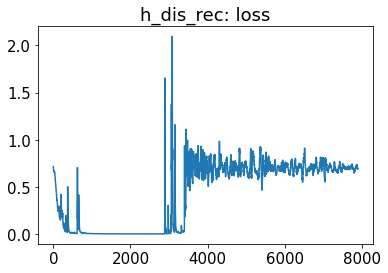

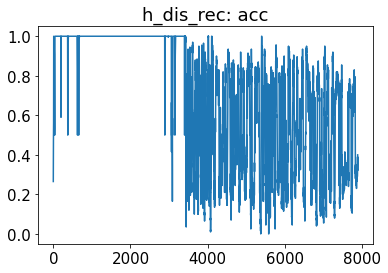

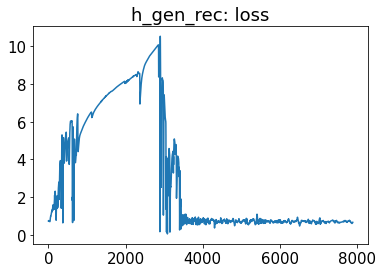

In [20]:
dis_recon = keras.Sequential([
    Dense(35, activation='relu'),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])
dis_recon.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

gen_recon = keras.Sequential([
    Dense(100, activation='relu'),
    Dense(76, activation='relu'),
    Dense(35, activation='sigmoid')
])
gen_recon.compile(optimizer='adam', loss='binary_crossentropy')


gan_recon = create_gan(dis_recon,gen_recon)

h_dis_rec, h_gen_rec = train(gan_recon, dis_recon, gen_recon, train_recon, 15, 100)

plt.title('h_dis_rec: loss')
plt.plot([h_dis_rec[y][0] for y in range(len(h_dis_rec))])
plt.show()

plt.title('h_dis_rec: acc')
plt.plot([h_dis_rec[y][1] for y in range(len(h_dis_rec))])
plt.show()

plt.title('h_gen_rec: loss')
plt.plot(h_gen_rec)
plt.show()

In [23]:
#print('itself:')
size= len(test_recon)
noise = np.random.uniform(0, 1, size=[size, 100])
generated_packets = gen_recon.predict(noise)
real_packets = test_recon[:size]
X1 = np.concatenate([real_packets, generated_packets])
y_dis1 = np.ones(2 * size)
y_dis1[size:] = 0
#dis_recon.evaluate(X, y_dis)
#roc_calc(dis_recon, X, y_dis)

#print('\n\nnormal:')
size= min(len(test_recon), len(normal_normalized))
generated_packets = normal_normalized[:size]
real_packets = test_recon[:size]
X2 = np.concatenate([real_packets, generated_packets])
y_dis2 = np.ones(2 * size)
y_dis2[size:] = 0
#dis_recon.evaluate(X, y_dis)
#roc_calc(dis_recon, X, y_dis)

#print('\n\ndos:')
size= min(len(test_recon), len(dos_normalized))
generated_packets = dos_normalized[:size]
real_packets = test_recon[:size]
X3 = np.concatenate([real_packets, generated_packets])
y_dis3 = np.ones(2 * size)
y_dis3[size:] = 0
#dis_recon.evaluate(X, y_dis)
#roc_calc(dis_recon, X, y_dis)

2469/2469 [==============================] - 3s 1ms/step - loss: 1.8258 - accuracy: 0.8333



No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


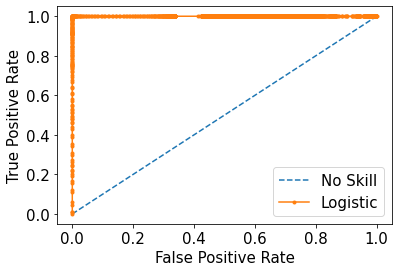

Accuracy: 0.8333333333333334
Precision: 0.875
Recall: 0.8333333333333334
F-score: 0.8285714285714286
MСС: 0.7071067811865476
ROC AUC: 1.0
Log Loss: 1.8256363962589428


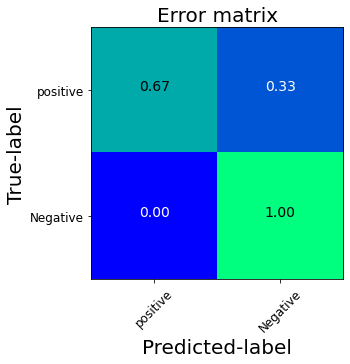

In [25]:
### FINAL CHECK FOR RECON DISCRIMINATOR
X = np.concatenate([X1, X2, X3])
Y = np.concatenate([y_dis1, y_dis2, y_dis3])
dis_recon.evaluate(X, Y)
print('\n\n')
roc_calc(dis_recon, X, Y)
y_predicted_proba = dis_recon.predict(X)
stat_name, stat_value = define_metrics(Y, np.round(y_predicted_proba), y_predicted_proba)
for i in range(len(stat_name)):
    print(stat_name[i] + ':', stat_value[i])
    

plot_confusion_matrix(Y, np.round(dis_recon.predict(X)))
plt.show()

  0%|▎                                                                                 | 2/598 [00:00<00:50, 11.69it/s]

--------------- Epoch 1 ---------------


  0%|▎                                                                                 | 2/598 [00:00<00:49, 11.94it/s]

--------------- Epoch 2 ---------------


  0%|▏                                                                                 | 1/598 [00:00<01:35,  6.23it/s]

--------------- Epoch 3 ---------------


  0%|                                                                                          | 0/598 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 598/598 [00:51<00:00, 11.69it/s]


--------------- Epoch 5 ---------------


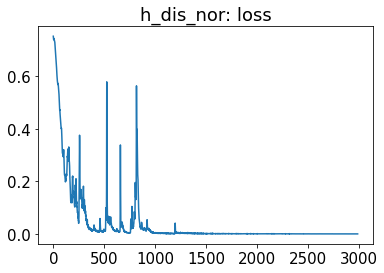

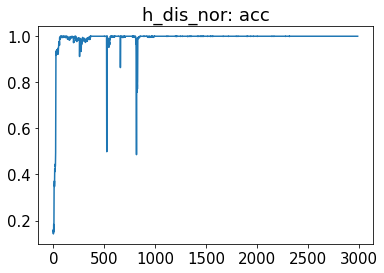

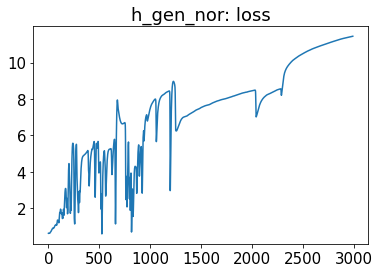

In [31]:
myAdam = keras.optimizers.Adam(learning_rate=0.001)

dis_normal = keras.Sequential([
    Dense(35, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')
])
dis_normal.compile(optimizer=myAdam, loss='binary_crossentropy', metrics=['accuracy'])

gen_normal = keras.Sequential([
    Dense(100, activation='relu'),
    Dense(70, activation='relu'),
    Dense(35, activation='sigmoid')
])
gen_normal.compile(optimizer=myAdam, loss='binary_crossentropy')


gan_normal = create_gan(dis_normal,gen_normal)

h_dis_nor, h_gen_nor = train(gan_normal, dis_normal, gen_normal, train_normal, 5, 500)

plt.title('h_dis_nor: loss')
plt.plot([h_dis_nor[y][0] for y in range(len(h_dis_nor))])
plt.show()

plt.title('h_dis_nor: acc')
plt.plot([h_dis_nor[y][1] for y in range(len(h_dis_nor))])
plt.show()

plt.title('h_gen_nor: loss')
plt.plot(h_gen_nor)
plt.show()

In [34]:
#print('itself:')
size= len(test_normal)
noise = np.random.uniform(0, 1, size=[size, 100])
generated_packets = gen_normal.predict(noise)
real_packets = test_normal[:size]
X1 = np.concatenate([real_packets, generated_packets])
y_dis1 = np.ones(2 * size)
y_dis1[size:] = 0
#dis_normal.evaluate(X, y_dis)
#roc_calc(dis_normal, X, y_dis)



#print('\n\nrecon:')
size= min(len(test_normal), len(recon_normalized))
generated_packets = recon_normalized[:size]
real_packets = test_normal[:size]
X2 = np.concatenate([real_packets, generated_packets])
y_dis2 = np.ones(2 * size)
y_dis2[size:] = 0
#dis_normal.evaluate(X, y_dis)
#roc_calc(dis_normal, X, y_dis)


#print('\n\ndos:')
size= min(len(test_normal), len(dos_normalized))
generated_packets = dos_normalized[:size]
real_packets = test_normal[:size]
X3 = np.concatenate([real_packets, generated_packets])
y_dis3 = np.ones(2 * size)
y_dis3[size:] = 0
#dis_normal.evaluate(X, y_dis)
#roc_calc(dis_normal, X, y_dis)


19081/19081 [==============================] - 18s 960us/step - loss: 0.2887 - accuracy: 0.9110



No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


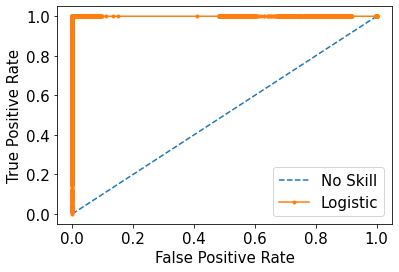

C:\Users\Евгений\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:2240: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\Евгений\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:2240: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Accuracy: 0.9109820132926714
Precision: 0.9244352560395069
Recall: 0.9109820132926714
F-score: 0.9102709824360533
MСС: 0.8353089393500037
ROC AUC: 1.0
Log Loss: nan


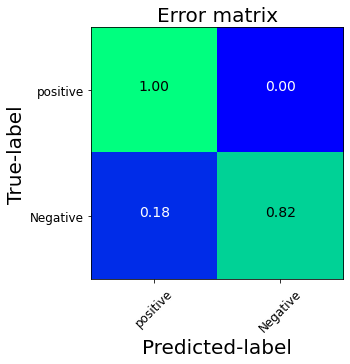

In [38]:
### FINAL CHECK FOR NORMAL DISCRIMINATOR
X = np.concatenate([X1, X2, X3])
Y = np.concatenate([y_dis1, y_dis2, y_dis3])
dis_normal.evaluate(X, Y)
print('\n\n')
roc_calc(dis_normal, X, Y)
y_predicted_proba = dis_normal.predict(X)
stat_name, stat_value = define_metrics(Y, np.round(y_predicted_proba), y_predicted_proba)
for i in range(len(stat_name)):
    print(stat_name[i] + ':', stat_value[i])
    

plot_confusion_matrix(Y, np.round(dis_normal.predict(X)))
plt.show()